# TP 2 - Motion Estimation

### Le Guillouzic Maël

This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [182]:
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

**Recall the expression of the 2D discrete time Fourier transform (DTFT).**

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). **Compute the DTFT** of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

**Show that the ratio between the DTFTs is:**
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

**Recall the expression of the DFT.**

**Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal?**
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

**Answer :** (Désolé pour la qualité, j'étais dans le TGV)

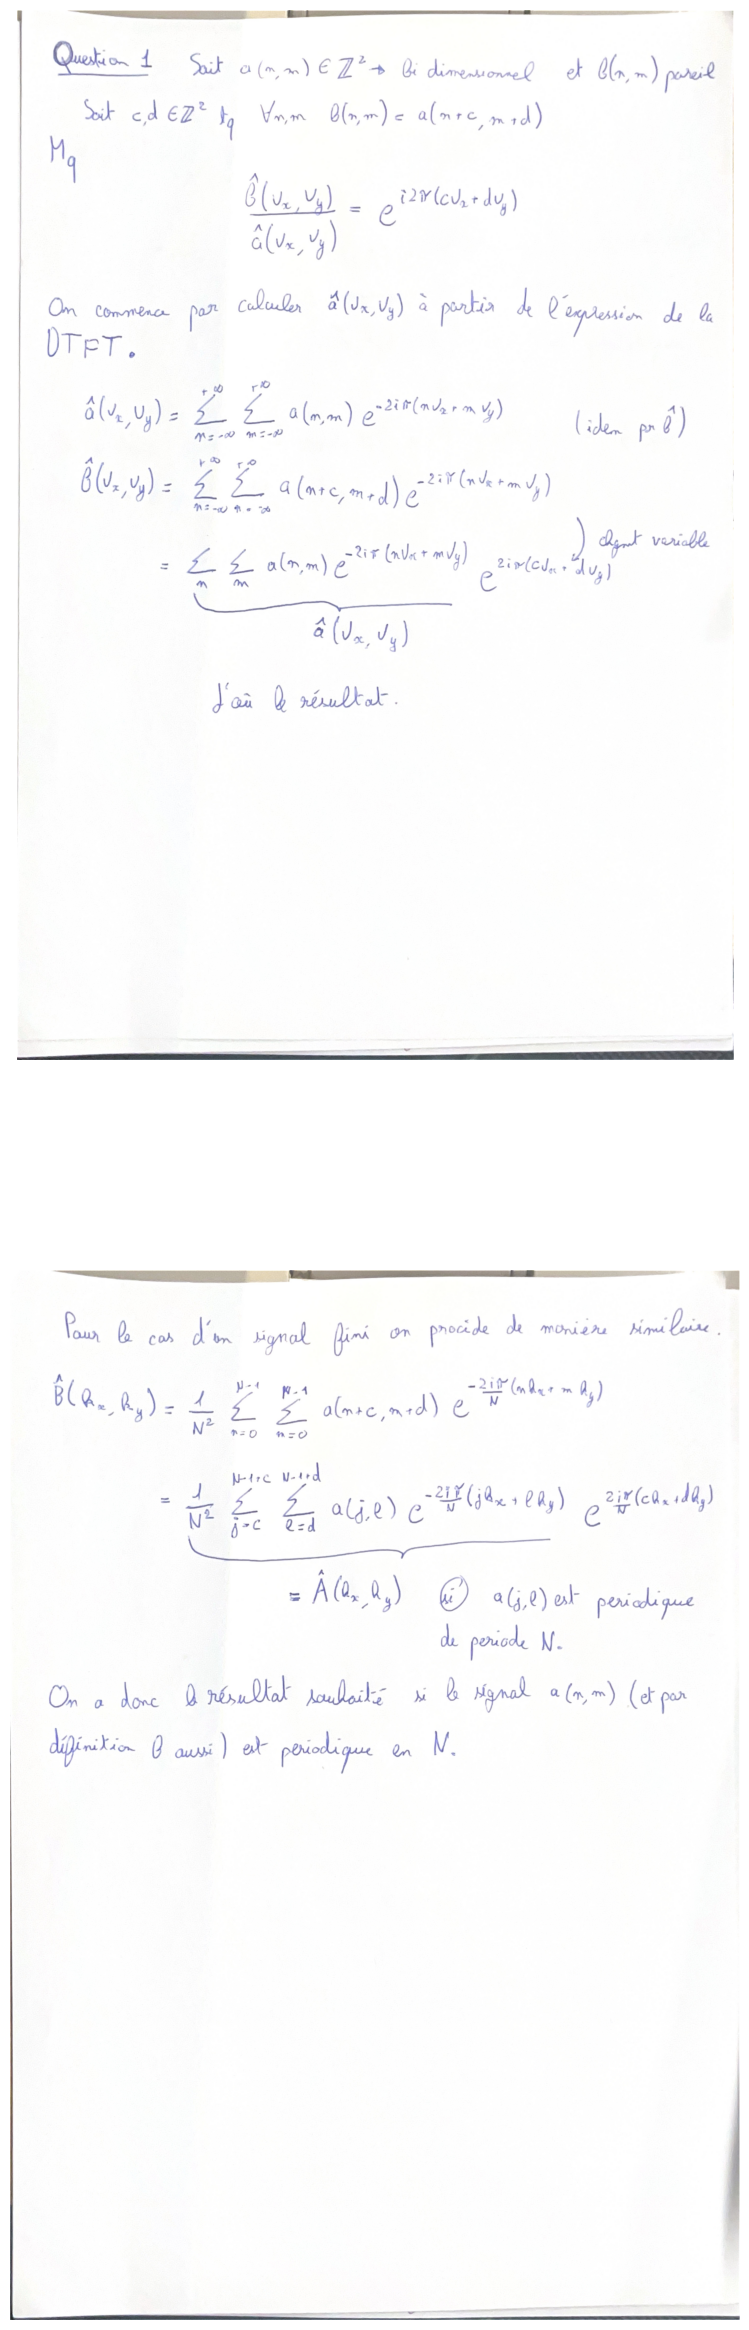

In [183]:
img1 = mpimg.imread('TP2theo1.jpg')
img2 = mpimg.imread('TP2theo2.jpg')
plt.figure(figsize=(14,30))
plt.subplot(211)
plt.imshow(img1)
plt.axis('off')
plt.subplot(212)
plt.imshow(img2)
plt.axis('off')
plt.show()

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x12b482490>)

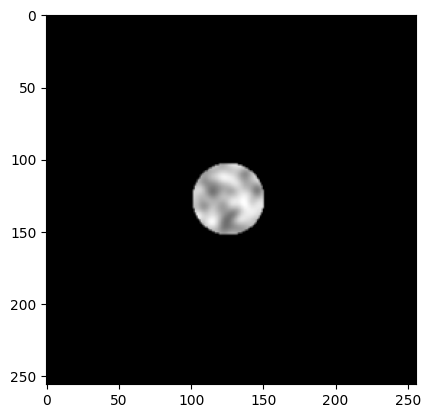

In [184]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

#im1 = loadmat('lena.mat')['im1']
#im1 = im1.astype('float')

N, M = np.shape(im1)
plt.figure(),plt.imshow(im1,cmap='gray')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x12afbb3d0>)

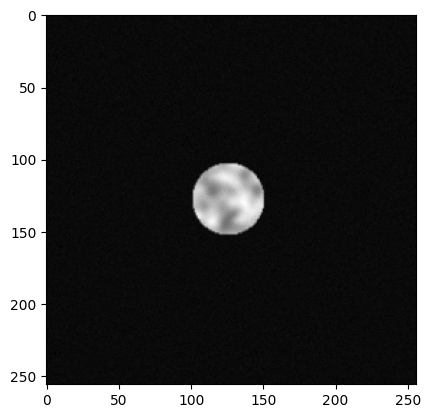

In [185]:
# Potentially add noise to the image
sigma = 2
im1nobruit = im1
im1 = im1 + sigma*np.random.randn(N,M)
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [186]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x12a159b90>)

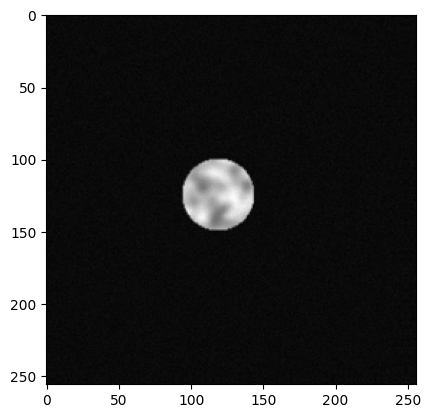

In [187]:
horiz_displacement = 7
vert_displacement  = 3
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
im2nobruit = applyAffineMotion(im1nobruit,b)
plt.figure(),plt.imshow(im2,cmap='gray')

**Question :** Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:** En calculant le ratio des deux FFT, d'après la partie théorique on obtient une exponentielle complexe qui dépend des paramètres de translation. En ne conservant donc que la phase du terme obtenu, on pourra identifier les paramètres de translation.

In [188]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [189]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [190]:
phi = angle2D(IM2/IM1)

**Question :** Display phi. Is it a linear plane and why?

**Answer:** On observe un plan "bruité", du au fait que l'on ai ajouté du bruit à notre image.

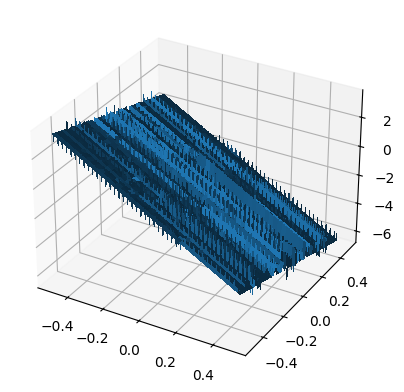

In [191]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [192]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns
    kx = np.array([[0, 0, 0],
                   [1, 0, -1],
                   [0, 0, 0]])
    ky = kx.T
    gy = convolve2d(M, ky, mode='same') / (2*stepY)
    gx = convolve2d(M, kx, mode='same') / (2*stepX)
    return gx,gy

In [193]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [194]:
print(GX)
print(GY)

-6.97040538892923
-2.8827588547537246


**Question :** Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

**Answer :** La fonction medianFilter prend en entrée un array auquel on veut appliquer la fonction, et une taille de fenetre N. Elle commence par recopier les bords pour éviter les problèmes avec les pixels aux bords, puis construit un output y de la meme shape que x. 

Puis pour chaque pixel, on calcule la médiane, de tous les pixels autour dans une fenetre de taille $(2N-1)*(2N-1)$ et on assigne cette valeur au meme emplacement dans y.

In [195]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [196]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [197]:
print(bEst)

[-6.81955029 -3.00443331]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

**Answer :** 
* **Pour la lune :** avec et sans bruit, on arrive toujours à estimer les paramètres de translation. On retrouve ainsi un plan phi linéaire puisque l'approximation de périodicité faite dans la partie théorique est respectée.

* **Pour Léna :** Phi ne suit plus un plan linéaire. La première méthode permet de se rapprocher du résultat mais n'est pas réellement proche du résultat voulu. La deuxième méthode ne trouve pas la bonne translation. On peut expliquer ces erreurs par le fait que Léna n'est pas periodique contrairement à l'image de la balle.

# II-Indirect parametric estimation
**Question :** In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

**Answer** On remprend ci dessous le code du TP1 pour calculer le mvf et l'afficher.

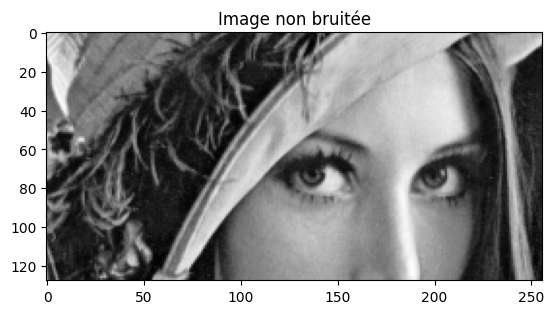

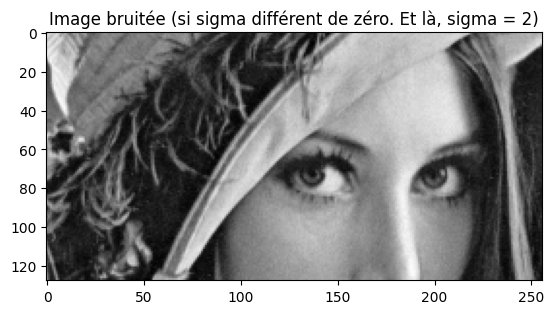

In [198]:
# im1 = loadmat('ball.mat')['im1']
# im1 = im1.astype('float')

im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

N, M = np.shape(im1)
plt.figure(),plt.imshow(im1,cmap='gray'), plt.title("Image non bruitée")


sigma = 2
im1 = im1 + sigma*np.random.randn(N,M)
plt.figure(),plt.imshow(im1,cmap='gray'), plt.title(f"Image bruitée (si sigma différent de zéro. Et là, sigma = {sigma})")

horiz_displacement = 7
vert_displacement  = 3
b = np.array([ horiz_displacement, vert_displacement])
im2 = applyAffineMotion(im1,b)

In [199]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

In [200]:
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo

    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of cols in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for i in range(0,np.shape(cur)[0]-brow+1,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for j in range(0,np.shape(cur)[1]-bcol+1,bcol):
                # current block selection
                B = cur[i:i+brow,j:j+bcol]

                # Initialization:
                costMin = np.inf
                Rbest = initVector(ref,cur)
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search+1): # rcol = candidate displacement vector over the rows
                        Bc = ref_extended[i+drow+extension:i+drow+extension+brow, j+dcol+extension:j+dcol+extension+bcol]
                        if np.shape(Bc) != np.shape(B):
                            print(f"Les blocs n'ont pas la meme taille. Taille de B (bloc de l'image current) : {np.shape(B)} et taille de Bc (bloc de l'image de reference) : {np.shape(Bc)}")
                            continue
                        cost = np.sum((B-Bc)**2) # SSD
                        if cost < costMin : # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = np.array([drow,dcol])
                            
                mvf[i:i+brow,j:j+bcol,0] = Rbest[0]
                mvf[i:i+brow,j:j+bcol,1] = Rbest[1]
                prediction[i:i+brow,j:j+bcol] = ref_extended[i+Rbest[0]+extension:i+Rbest[0]+extension+brow, j+Rbest[1]+extension:j+Rbest[1]+extension+bcol]
                
    else: # Regularized search
        print("Régularisation pas encore implémentée : à faire")
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [201]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')
    plt.quiver(X, Y, vectCol,-vectRow)
    plt.show()

    return

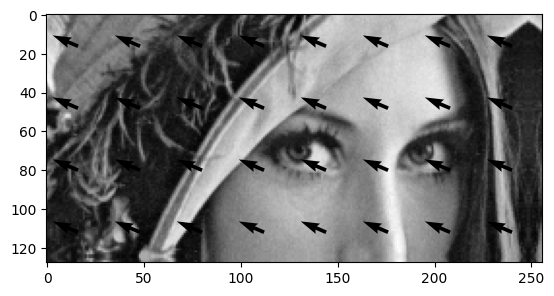

-7.0
-3.0


In [202]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

### Estimation with optic flow

On reprend de la même manière le code du TP1 ci dessous.

In [203]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = cv2.filter2D(u,-1,kernel_1)
        vAvg = cv2.filter2D(v,-1,kernel_1)
        
        num = (fx * uAvg + fy * vAvg + ft)
        denom = alpha**2 + fx**2 + fy**2
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx * num / denom
        v = vAvg - fy * num / denom
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

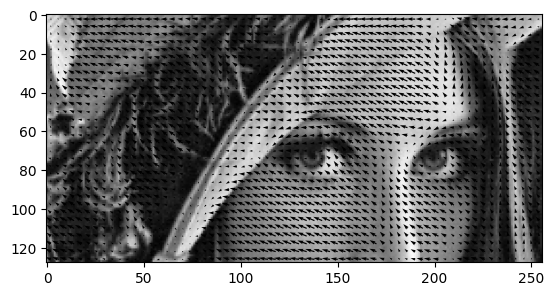

-3.900190453730239
-2.241156175297977


In [204]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

**Conclusions :**

Pour des valeurs entières de translation, on observe les résultats suivants.
* **Lune :** Les deux méthodes trouvent une trabslation de 10,10 alors qu'elle est de 7,3 ... Etrange ...

* **Lune bruitée (sigma=2):** Idem que pour la question précédente ?!?

* **Léna :** On retrouve exactement ! les paramètres avec la méthode SSD en utilisant de gros blocs. Mais avec le flow optique on n'y est pas. On remarque que la performance parfaite du SSD est en fait due au fait qu'il utilise de très gros blocs, ce qui pour un mouvement linéaire est idéal puisqu'il capte le mouvement global de l'image la ou le flox optique se perd un peu.

* **Léna bruitée (sigma=2):** Meme chose que pour le cas non bruité.

Pour des valeurs non entières, les deux méthodes sont moins performantes. J'obtiens néanmoins de meilleurs résultats avec la méthode SSD et de gros blocs.